 У завданні 2 використано VGG16.   Однак VGG16 вимагає багато ресурсів, тому я використала розмір зображення 48×48. В результаті я не змогла досягти бажаного збільшення точності у навчанні.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import datasets
import numpy as np
import gc

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

0

In [ ]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

TRAIN_SAMPLES = 30000
x_train = x_train[:TRAIN_SAMPLES]
y_train = y_train[:TRAIN_SAMPLES]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x_train = x_train[..., np.newaxis].astype('float32') / 255.0
x_test = x_test[..., np.newaxis].astype('float32') / 255.0

x_train = tf.image.resize(x_train, (48, 48))
x_test = tf.image.resize(x_test, (48, 48))

x_train = tf.image.grayscale_to_rgb(x_train)
x_test = tf.image.grayscale_to_rgb(x_test)

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

gc.collect()

7

In [ ]:
# Створення базової моделі
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(48, 48, 3)
)
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Створення повної моделі
inputs = layers.Input(shape=(48, 48, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs, outputs)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow(
    x_train, y_train,
    batch_size=64,
    subset='training'
)

validation_generator = datagen.flow(
    x_train, y_train,
    batch_size=64,
    subset='validation'
)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 855s 2s/step - accuracy: 0.2865 - loss: 2.0692 - val_accuracy: 0.7295 - val_loss: 0.9824
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 851s 2s/step - accuracy: 0.6612 - loss: 1.0353 - val_accuracy: 0.7625 - val_loss: 0.7552
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 859s 2s/step - accuracy: 0.7081 - loss: 0.8489 - val_accuracy: 0.7718 - val_loss: 0.6752
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 898s 2s/step - accuracy: 0.7431 - loss: 0.7435 - val_accuracy: 0.7768 - val_loss: 0.6345
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 882s 2s/step - accuracy: 0.7504 - loss: 0.7044 - val_accuracy: 0.7887 - val_loss: 0.6040
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 883s 2s/step - accuracy: 0.7561 - loss: 0.6724 - val_accuracy: 0.7968 - val_loss: 0.5779
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 917s 2s/step - accuracy: 0.7651 - loss: 0.6590 - val_accuracy: 0.8048 - val_loss: 0.5626
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 919s 2s/step - accuracy: 0.7749 - loss: 0.6340 - val_accuracy: 0.807

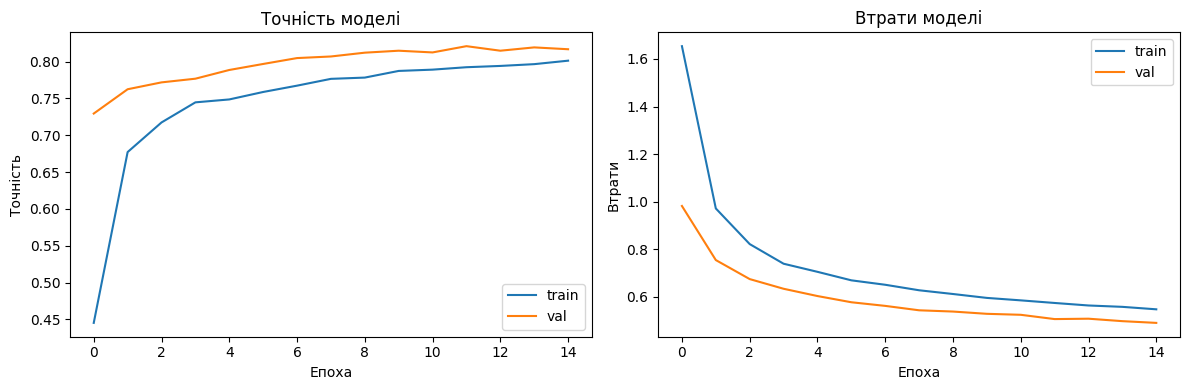

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Точність моделі')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Втрати моделі')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()

plt.tight_layout()
plt.show()